# Cluster-II workflow

This notebook presents a computational workflow to detect trees from aerial imagery with a train/test split of image tiles based on a two-level *k*-means clustering of image descriptors. The first level *k*-means divides the dataset into 4 clusters of image tiles. Within each cluster, the second level *k*-means is used to select the image tiles for training in a way that enhances the variety of scenes represented in the training tiles. The selected tiles will be used to train a **separate classifier** dedicated to the tiles in such first level cluster.

In [ ]:
import os
from os import path

import detectree as dtr
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio import plot

from detectree_examples import make_confusion_df, make_response_tiles

figwidth, figheight = plt.rcParams["figure.figsize"]
%matplotlib inline

In [ ]:
img_dir = "../data/interim/tiles"
lidar_tiles_filepath = "../data/raw/lidar/lidar2014.shp"
raw_lidar_dir = "../data/raw/lidar"
response_dir = "../data/interim/response-tiles"
pred_tiles_dir = "../data/interim/pred-tiles"
output_dir = "../data/interim/cluster-II-pred-tiles"

Let us now use the Makefile at the root of this repository ensure that we have the required data input data - i.e., the tiles from [Zurich's RGB orthophoto of summer 2014/15](https://www.geolion.zh.ch/geodatensatz/2831) that lie within Zurich's municipal boundaries - has been downloaded (see [the background notebook](https://github.com/martibosch/detectree-example/blob/main/notebooks/background.ipynb) for more details).

In [ ]:
!make -C .. tiles

make: Entering directory '/home/martibosch/data-science/detectree-examples'
make: Nothing to be done for 'tiles'.
make: Leaving directory '/home/martibosch/data-science/detectree-examples'


## Train/test split

In order to select which image tiles are to be used to train the classifier, we will follow the 'Cluster-I' method described in Yang et al. [1], which consists of the following steps (see [the background notebook](https://github.com/martibosch/detectree-example/blob/main/notebooks/background.ipynb) for more details on the procedure):

1. Compute image descriptors [2] for each tile of the dataset
2. Apply *k*-means to the image descriptors to divide the dataset into 4 first-level clusters
3. Within each first-level cluster, apply a second-level *k*-means to the image descriptors with the number of clusters that corresponds to the number of tiles that are to be used to train the classifier, i.e., in a first-level cluster of 400 tiles and a desired 1% of training tiles, the number of second-level clusters would be set to 4.
4. Within each first-level cluster, select the tiles that are closest to each cluster's centroid to train **a separate classifier** dedicated to the tiles in such first-level cluster.

In detectree, the above procedure is done with the `train_test_split` method of the `TrainingSelector` class. Note that the initialization of `TrainingSelector` accepts a set of keyword arguments to customize how the image descriptors are computed (see [its documentation](https://detectree.readthedocs.io/en/latest/train_test_split.html#detectree.TrainingSelector.__init__) for more details).

In [ ]:
ts = dtr.TrainingSelector(img_dir=img_dir)

In order to reduce the computational cost of the *k*-means clustering, Principal Component Analysis (PCA) is be used to reduce the dimensionality of the image descriptors, e.g., to 24 components. This is specified in the `n_components` keyword argument of the `train_test_split` method.

After the instantiation of a `TrainingSelector`, its `train_test_split` method can be used as follows (the processing can take a while since it involves the computation of the image descriptor for each tile):

In [ ]:
split_df, evr = ts.train_test_split(
    method="cluster-II", n_components=24, return_evr=True
)

[########################################] | 100% Completed | 52.70 s
[                                        ] | 0% Completed | 136.81 ms

/home/martibosch/miniforge3/envs/detectree/lib/python3.12/site-packages/detectree/pixel_features.py:121: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  neighborhood = morphology.square(2 * min_neighborhood_range + 1)


[########################################] | 100% Completed | 2.94 ss
[                                        ] | 0% Completed | 3.23 ss

/home/martibosch/miniforge3/envs/detectree/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[########################################] | 100% Completed | 3.33 s
[####################                    ] | 50% Completed | 3.90 s

/home/martibosch/miniforge3/envs/detectree/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[########################################] | 100% Completed | 4.00 s
[########################################] | 100% Completed | 4.17 s


/home/martibosch/miniforge3/envs/detectree/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martibosch/miniforge3/envs/detectree/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martibosch/miniforge3/envs/detectree/lib/python3.12/site-packages/detectree/pixel_features.py:121: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  neighborhood = morphology.square(2 * min_neighborhood_range + 1)
/home/martibosch/miniforge3/envs/detectree/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

The `train_test_split` method returns a pandas data frame with the train test split. Additionally, if `return_evr` is `True`, `train_test_split` also returns the variance ratio explained by the PCA, which in this case is:

In [ ]:
evr

np.float64(0.9187597879139477)

The data frame of the train/test split looks as follows:

In [ ]:
split_df.head()

img_filename  img_cluster  train
0  1091-232_01.tif            0  False
1  1091-411_23.tif            0  False
2  1091-411_04.tif            1  False
3  1091-322_05.tif            0  False
4  1091-411_02.tif            1  False

The `img_cluster` column features the label of the first-level clustering. The tiles to be used to train each cluster's classifier are the following ones:

In [ ]:
split_df[split_df["train"]]

img_filename  img_cluster  train
5    1091-231_07.tif            0   True
28   1091-234_14.tif            1   True
62   1091-431_14.tif            0   True
98   1091-231_10.tif            3   True
139  1091-413_23.tif            2   True
248  1091-414_04.tif            1   True

Note that since our dataset is relatively small (225 tiles) and we are only selecting 1% of the tiles for training, only 1 tile has been selected for training in each of the 4 first-level clusters.

## Interlude: computing the responses from LIDAR data

Since detectree uses a supervised learning approach, we need to manually provide the responses (i.e., binary images representing the ground-truth tree/non-tree masks) for the training tiles so that the tree/non-tree pixel classifier can be trained.

There are many ways to obtain such masks, the most straight-forward being manual edition in a raster graphics editor software such as [GIMP](https://www.gimp.org/). In the case of this example dataset, the ground-truth masks can be extracted from [Zurich's 2014 LIDAR dataset](https://www.geolion.zh.ch/geodatensatz/show?gdsid=343). Such task is accomplished in the two cells below, whose content is out of the scope of detectree.

In [ ]:
!make -C .. download_lidar_shp

make: Entering directory '/home/martibosch/data-science/detectree-examples'
make: Nothing to be done for 'download_lidar_shp'.
make: Leaving directory '/home/martibosch/data-science/detectree-examples'


In [ ]:
lidar_gdf = gpd.read_file(lidar_tiles_filepath)

if not path.exists(response_dir):
    os.mkdir(response_dir)

response_tiles = make_response_tiles.make_response_tiles(
    split_df, lidar_gdf, img_dir, raw_lidar_dir, response_dir
)

Let us now plot side by side the training tiles (left) and the LIDAR-based ground-truth masks.

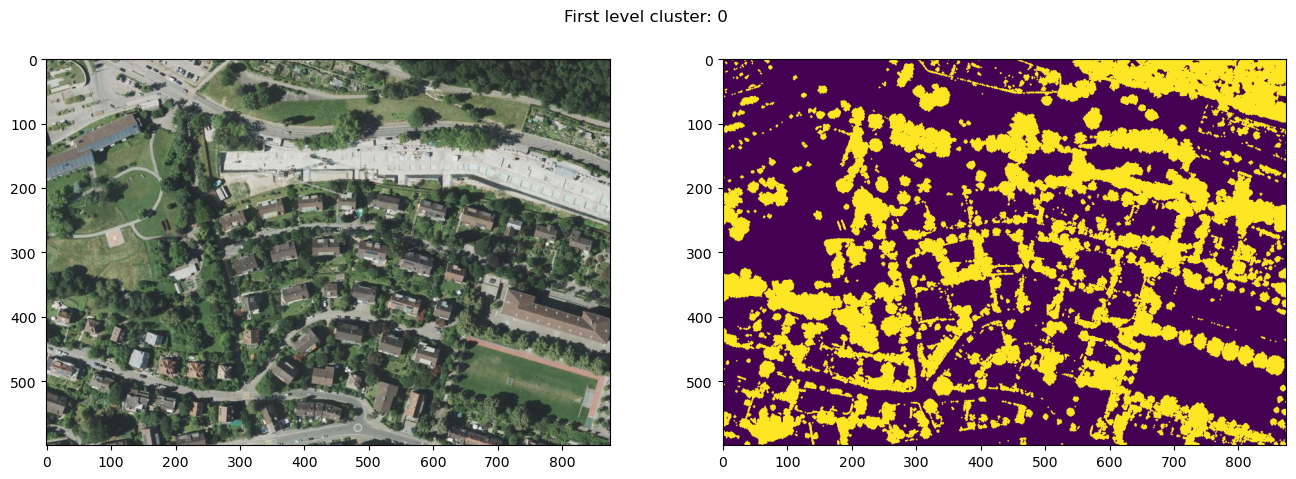

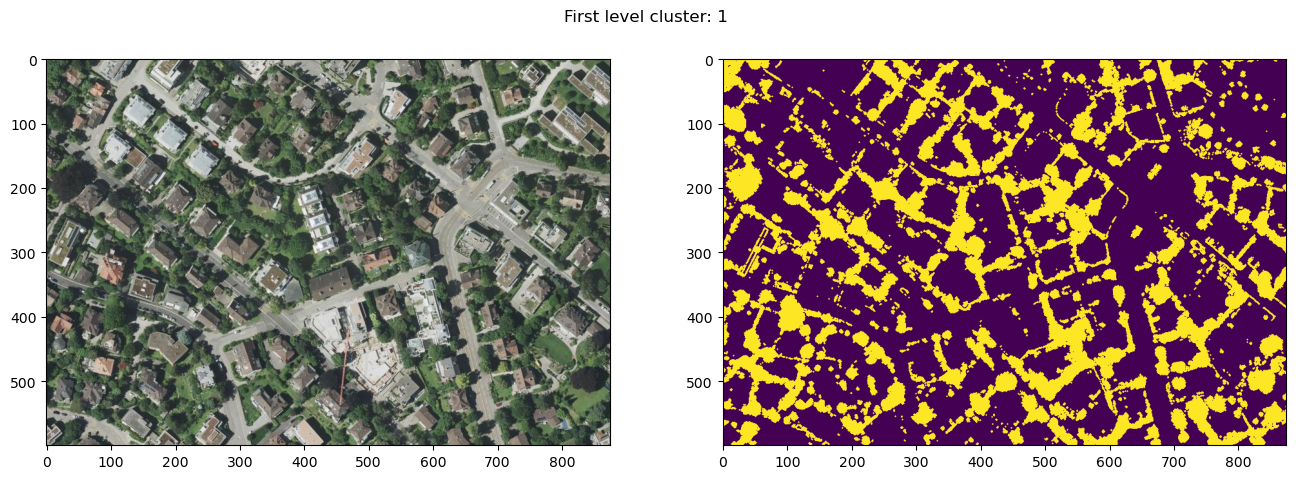

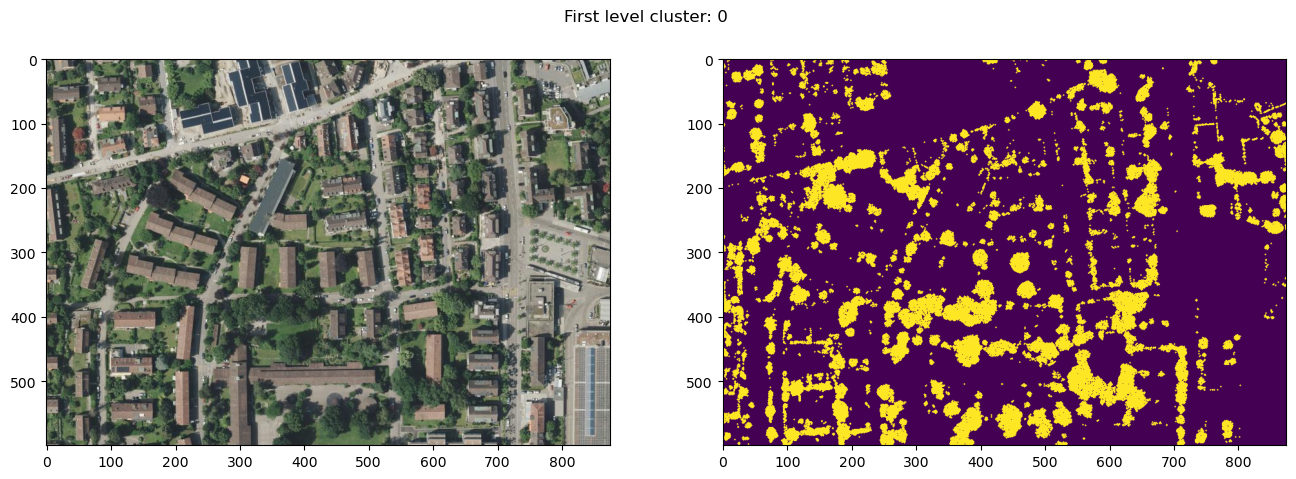

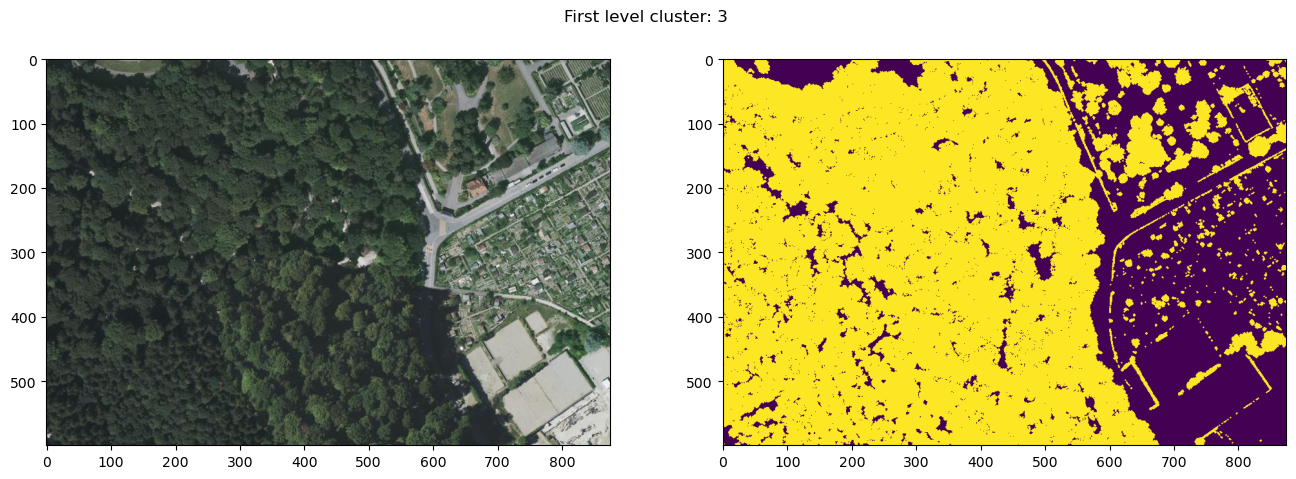

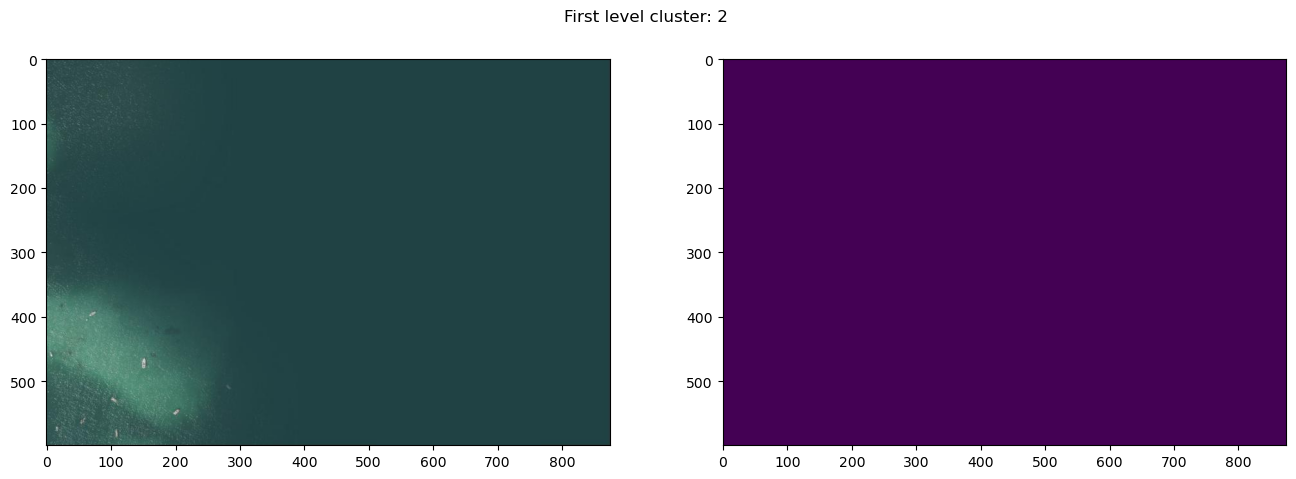

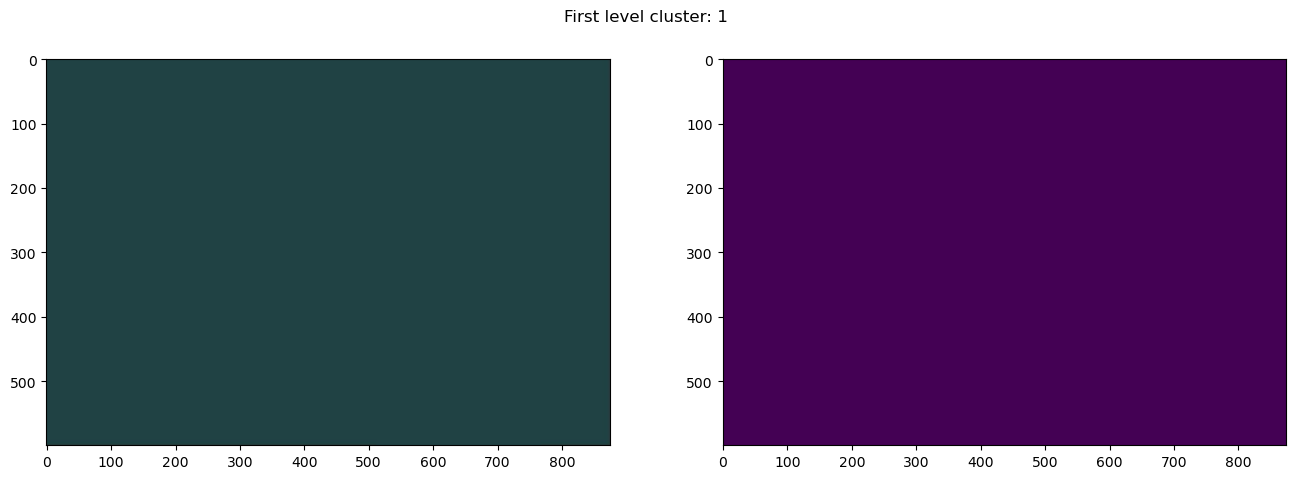

In [ ]:
train_df = split_df[split_df["train"]]
for img_filename, img_cluster in zip(train_df["img_filename"], train_df["img_cluster"]):
    fig, axes = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))
    fig.suptitle(f"First level cluster: {img_cluster}", y=0.9)
    with rio.open(path.join(img_dir, img_filename)) as src:
        plot.show(src.read(), ax=axes[0])
    with rio.open(path.join(response_dir, img_filename)) as src:
        plot.show(src.read(), ax=axes[1])

Note that accuracy of the ground-truth masks is crucial to train a good classifier.

## Training the classifiers (note the final "s")

We can now proceed to the training of the classifier. In detectree, this can be done with the `train_classifiers` (not to be confused with `train_classifier`, note the final "s") method of the `ClassifierTrainer` class, which takes two positional arguments: the train/test split data frame and the directory of the response images (see [its documentation](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.ClassifierTrainer.train_classifiers) for more details). The training of the classifier can be customized by providing a set of keyword arguments to the initialization of `ClassifierTrainer` (see [its documentation](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.ClassifierTrainer.__init__) for more details). Note that the training of the classifier can take some time.

In [ ]:
clf_dict = dtr.ClassifierTrainer().train_classifiers(split_df, img_dir, response_dir)

[LightGBM] [Warning] Contains only one class 0% Completed | 4.27 s ms
[LightGBM] [Info] Number of positive: 0, number of negative: 525000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6846
[LightGBM] [Info] Number of data points in the train set: 525000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no m

The returned object is a dictionary mapping the label of the first-level cluster to its trained [`LightGBMClassifier`](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html) instance.

In [ ]:
clf_dict

{0: LGBMClassifier(n_estimators=200),
 1: LGBMClassifier(n_estimators=200),
 2: LGBMClassifier(n_estimators=200),
 3: LGBMClassifier(n_estimators=200)}

## Predicting tree/non-tree labels

The dictionary of trained classifiers can be used to predict the tree/non-tree labels from any given image of the dataset. To that end, detectree provides the `Classifier` class, which features a `predict_img` method that can be (see [its documentation](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.Classifier.predict_img) for more details).

/home/martibosch/miniforge3/envs/detectree/lib/python3.12/site-packages/detectree/pixel_features.py:121: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  neighborhood = morphology.square(2 * min_neighborhood_range + 1)
/home/martibosch/miniforge3/envs/detectree/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


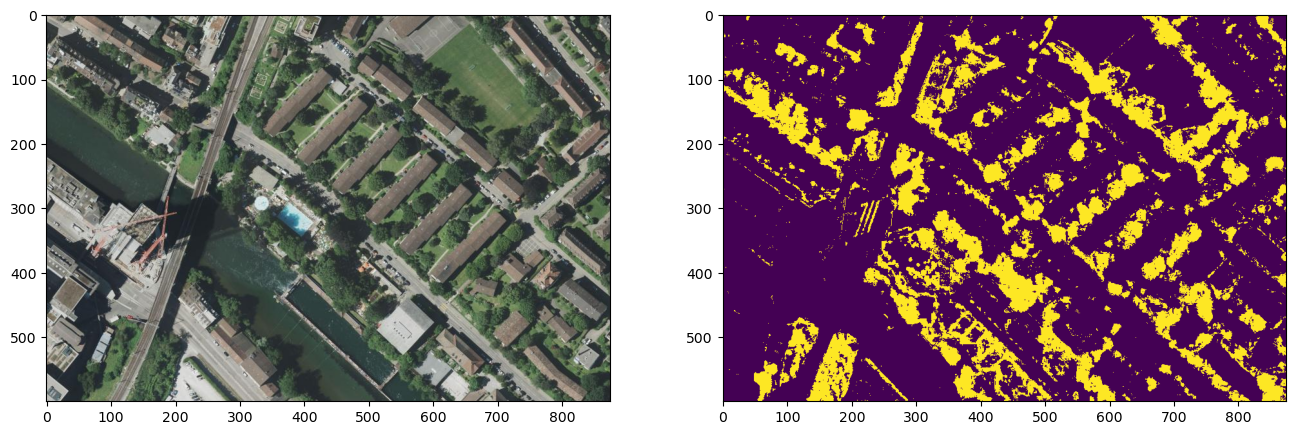

In [ ]:
test_filename, img_cluster = (
    split_df[~split_df["train"]][["img_filename", "img_cluster"]].sample(1).iloc[0]
)
test_filepath = path.join(img_dir, test_filename)

c = dtr.Classifier(clf_dict=clf_dict)

# to predict a single image with a classifier instantiated with `clf_dict`, we need to
# specify the image's cluster using the `img_cluster` argument
y = c.predict_img(test_filepath, img_cluster=img_cluster)

fig, axes = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))
with rio.open(test_filepath) as src:
    plot.show(src.read(), ax=axes[0])
axes[1].imshow(y)

Note that in order to predict a single image with a classifier instantiated with `clf_dict`, we need to specify the image's cluster using the `img_cluster` argument. If multiple tiles are to be classified, it might be more appropriate to use the `predict_imgs` method, which operates directly on the train/test split data frame and the dictionary of classifiers `clf_dict` (see [its documentation](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.Classifier.predict_imgs) for more details), and uses dask to classify the tiles in parallel.

In [ ]:
if not path.exists(output_dir):
    os.mkdir(output_dir)

sample_df = split_df.sample(20)
pred_tiles = c.predict_imgs(sample_df, img_dir, output_dir)

[########################################] | 100% Completed | 37.64 s
[########################################] | 100% Completed | 30.37 s
[########################################] | 100% Completed | 5.43 ss


The returned `pred_tiles` is a dictionary mapping each first-level cluster to its respective list of paths predicted tiles.

In [ ]:
pred_tiles

{0: ['../data/interim/cluster-II-pred-tiles/1091-142_24.tif',
  '../data/interim/cluster-II-pred-tiles/1091-431_07.tif',
  '../data/interim/cluster-II-pred-tiles/1091-213_20.tif',
  '../data/interim/cluster-II-pred-tiles/1091-142_10.tif',
  '../data/interim/cluster-II-pred-tiles/1091-413_03.tif',
  '../data/interim/cluster-II-pred-tiles/1091-124_16.tif',
  '../data/interim/cluster-II-pred-tiles/1091-413_19.tif',
  '../data/interim/cluster-II-pred-tiles/1091-414_12.tif',
  '../data/interim/cluster-II-pred-tiles/1091-411_22.tif',
  '../data/interim/cluster-II-pred-tiles/1091-144_09.tif'],
 1: ['../data/interim/cluster-II-pred-tiles/1091-124_17.tif',
  '../data/interim/cluster-II-pred-tiles/1091-213_23.tif',
  '../data/interim/cluster-II-pred-tiles/1091-322_14.tif',
  '../data/interim/cluster-II-pred-tiles/1091-412_01.tif',
  '../data/interim/cluster-II-pred-tiles/1091-322_17.tif',
  '../data/interim/cluster-II-pred-tiles/1091-124_13.tif',
  '../data/interim/cluster-II-pred-tiles/1091-322

## Validation

In order to evaluate the accuracy of the classifier, we can use the code below to build a confusion matrix, which uses the LIDAR dataset to compute the ground-truth masks. The `frac` keyword argument sets the fraction of tiles that will be randomly-sampled and used for validation.

In [ ]:
confusion_df = make_confusion_df.make_confusion_df(
    lidar_gdf,
    raw_lidar_dir,
    response_dir,
    split_df=split_df,
    img_dir=img_dir,
    frac=0.01,
    clf_dict=clf_dict,
)
confusion_df

[########################################] | 100% Completed | 109.86 s


predicted       0         255
actual                       
0          0.630671  0.077222
255        0.057256  0.234851

We can compute the accuracy, precision, recall and F1-score from the confusion matrix:

In [ ]:
accuracy, precision, recall, f1 = make_confusion_df.compute_metrics(confusion_df)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Accuracy: 0.8655219047619047
Precision: 0.7525507868528937
Recall: 0.8039898449794377
F1: 0.7774203616500084


## References

1. Yang, L., Wu, X., Praun, E., & Ma, X. (2009). Tree detection from aerial imagery. In Proceedings of the 17th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems (pp. 131-137). ACM.

2. Oliva, A., & Torralba, A. (2001). Modeling the shape of the scene: A holistic representation of the spatial envelope. International journal of computer vision, 42(3), 145-175.